# Tutorial: How to optimize a Neural Topic Model (Contextualized Topic Models) with OCTIS

Welcome! This is a tutorial that allows you to optimize the hyperparameters of a neural topic model using OCTIS (Optimizing and Comparing Topic Models Is Simple). 

![](https://github.com/MIND-Lab/OCTIS/blob/master/logo.png?raw=true)

A topic model allows you to discover the latent topics in your documents in a completely unsupervised way. But to find the best results, you usually need to optimize its hyperparameters. Let's optimize the hyperparameters of the [Zero-shot Contextualized Topic Model](https://github.com/MilaNLProc/contextualized-topic-models), that is already integrated into OCTIS. It's very easy :)

## Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

[Reference](https://colab.research.google.com/notebooks/gpu.ipynb)


## Installing OCTIS

We need to install OCTIS. (We are going to use the library version of OCTIS, but you can also use it through its dashboard. See https://github.com/mind-Lab/octis for more details.)

In [1]:
!pip install octis

     |████████████████████████████████| 112kB 8.3MB/s 
     |████████████████████████████████| 174kB 14.2MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
     |████████████████████████████████| 2.1MB 14.5MB/s 
     |████████████████████████████████| 1.2MB 49.6MB/s 
     |████████████████████████████████| 3.3MB 57.4MB/s 
     |████████████████████████████████| 901kB 52.5MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=233331 sha256=522fc3a95e9635cabe7fbd6061ee1d62610980c31425a1fa958571b7ecb4c34b
  Stored in directory: /root/.cache/pip/wheels/5e/9e/b5/dbb033107407eec2f52b8cd24cf024a4b9ec8b62ea5aee995a
  Created wheel for sentence-transformers: filename=sentence_transformers-1.0.4-cp37-none-any.whl size=114307 sha256=af73392513382dae317aba9aafc8a677459a3a86f49392ea400001eabd7e13ca
  Stored in directory: /root/.cache/pip/wheels/26/ea/89/d0d2e013d951b6d23270aa9ca4018b82632ab7cd933c33

Let's import what we need. 

In [2]:
from octis.models.CTM import CTM
from octis.dataset.dataset import Dataset
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.evaluation_metrics.coherence_metrics import Coherence

## Load Data
We need some data to run a topic model. OCTIS already provides 4 already-preprocessed datasets. Let's use one of them.

In [3]:
dataset = Dataset()
dataset.fetch_dataset("M10")

## Load Topic Model
The zero-shot version of the [Contextualized Topic Model](https://github.com/MilaNLProc/contextualized-topic-models) is a very recent approach that is based on a Variational Autoencoder and replaces the classical input Bag-of-Words representation with a pre-trained contextualized representation of the document. (See its original paper here: https://arxiv.org/abs/2004.07737)

Let's define the topic model and the hyperparameters that we want to fix. Let's set the `number of topics` and the `maximum number of epochs`. The dataset is split in training, validation and testing. The model will stop with an early stopping criterion. We also define the `inference_type` parameter to run the zero-shot CTM (otherwise you can specify `combined` to run the combined CTM version of the model). Finally, we select the language model that we want to use. Here we use `sentence-transformers's RoBERTa`, but you can use whatever language model you like (https://huggingface.co/sentence-transformers).

In [4]:
model = CTM(num_topics=10, num_epochs=30, inference_type='zeroshot', bert_model="bert-base-nli-mean-tokens")

## Define Evaluation Metric

We want to find the best hyperparameter configuration of CTM for the topic coherence. So, we initialize the topic coherence. We are going to use the well-know NPMI topic coherence, but we provide a wide range of different measures. See here: https://github.com/MIND-Lab/OCTIS/blob/master/octis/evaluation_metrics/coherence_metrics.py 

We are going to compute the word co-occurrences of the topic coherence on the dataset itself. 

In [5]:
npmi = Coherence(texts=dataset.get_corpus())

## Define Hyperparameter Search Space 

Now we are going to define the search space for the optimization algorithm. We need to specify the type of each hyperparameter (`Categorical`, `Integer` or `Real`). If it's Categorical (e.g. the activation function), we need to list the possibile values, otherwise (e.g. the dropout) we specify the lower and upper bounds of the hyperparameter. 

Note that we choose to define the number of neurons as categorical to reduce the search space. Instead of considering all the possible 200 values between 100 and 300, we reduce the search to possible 3 values. 

In [6]:
search_space = {"num_layers": Categorical({1, 2, 3}), 
                "num_neurons": Categorical({100, 200, 300}),
                "activation": Categorical({'sigmoid', 'relu', 'softplus'}), 
                "dropout": Real(0.0, 0.95)
}

####Which is the correct the number of optimization iterations?

It's a threshold between how much time you want to spend on an experiment and how much accurate you want your experiments to be. **Recall that the more hyperparameters to optimize you have, the more iterations you need to do.** 
As a rule of thumb, if you have *N* hyperparameters to optimize, then you should make at least *15 times N* iterations. 


We can also set the number of **model's runs**. Topic models are usually probabilistic and thus produce different results even with the same hyperparameter configuration. So we run the model for times and then take the median of the evaluated metric to get a more reliable result.

Since we just want to show the functionalities of OCTIS, we are going to set a low number of iterations and models' runs. Feel free to change the following numbers for more robust results.  

In [7]:
optimization_runs=30
model_runs=1

We are ready to launch the hyperparameter optimization. Let's define our Optimizer and give it our CTM model, the search space, the metric to evaluate and the other parameters.

We are going to save the models' results in the folder "results/test_ctm". In this way, you can retrieve the results and use them later to further analysis.

*Optional*: You can keep track of other evaluation metrics while you are optimizing for a specified metric. Just define the metrics that you want to evaluate, append them to a list and use them as the parameter `extra_metrics` of the `Optimizer.optimize` method.

Now just wait for the experiment to complete.. it will take some time :)

In [8]:
optimizer=Optimizer()
optimization_result = optimizer.optimize(
    model, dataset, npmi, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, save_models=True, 
    extra_metrics=None, # to keep track of other metrics
    save_path='results/test_ctm//')

Current call:  0



Current call:  1
Current call:  2
Current call:  3
Current call:  4
Current call:  5
Current call:  6
Current call:  7
Current call:  8
Current call:  9
Current call:  10
Current call:  11
Current call:  12
Current call:  13
Current call:  14
Current call:  15
Current call:  16
Current call:  17
Current call:  18
Current call:  19
Current call:  20
Current call:  21
Current call:  22
Current call:  23
Current call:  24
Current call:  25
Current call:  26
Current call:  27
Current call:  28
Current call:  29


The summary of the results are stored in the file "results.json" in the results folder. But you can also save the main results of the optimization in a csv file. 

In [9]:
optimization_result.save_to_csv("results_ctm.csv")

## Analysis of the results

Let's inspect the optimization results. Just load the results file. This is the information that is stored. 

In [10]:
import json
res = json.load(open("results/test_ctm/result.json",'r'))
res.keys()

dict_keys(['dataset_name', 'dataset_path', 'is_cached', 'kernel', 'acq_func', 'surrogate_model', 'optimization_type', 'model_runs', 'save_models', 'save_step', 'save_name', 'save_path', 'early_stop', 'early_step', 'plot_model', 'plot_best_seen', 'plot_name', 'log_scale_plot', 'search_space', 'model_name', 'model_attributes', 'use_partitioning', 'metric_name', 'extra_metric_names', 'metric_attributes', 'extra_metric_attributes', 'current_call', 'number_of_call', 'random_state', 'x0', 'y0', 'n_random_starts', 'initial_point_generator', 'topk', 'time_eval', 'dict_model_runs', 'f_val', 'x_iters'])

The key "x_iters" is a dictionary containing the values of a given hyperparameter for each iteration. For example, these are the evaluated values of the hyperparameter "activation" across all the iterations. 

In [11]:
res['x_iters']['activation']

['sigmoid',
 'softplus',
 'relu',
 'softplus',
 'sigmoid',
 'sigmoid',
 'sigmoid',
 'relu',
 'sigmoid',
 'sigmoid',
 'softplus',
 'softplus',
 'softplus',
 'softplus',
 'relu',
 'relu',
 'relu',
 'sigmoid',
 'relu',
 'sigmoid',
 'relu',
 'sigmoid',
 'sigmoid',
 'relu',
 'sigmoid',
 'relu',
 'softplus',
 'sigmoid',
 'softplus',
 'relu']

And this is the values of the function across all the iterations. Just use the key "f_val". 

In [12]:
res["f_val"]

[-0.0811958384022877,
 -0.026938754847881226,
 0.023606570633877395,
 0.026978306655116246,
 0.053657605213730954,
 -0.12804161214591037,
 -0.014701411443803497,
 -0.007806547779232728,
 0.03206141047206094,
 -0.025363665885419405,
 -0.16159967411785928,
 -0.033399039165565456,
 -0.022945431819161442,
 -0.008497785382228052,
 0.013488975998346347,
 0.01433232434558565,
 0.04710382400465463,
 -0.22789569333803864,
 0.007068519274295124,
 -0.13388267266662082,
 0.021942407221298737,
 0.016968538353056145,
 -0.034584000079006944,
 -0.04315644217904248,
 0.00796113614067216,
 -0.016843512118015512,
 -0.16150485448077895,
 -0.06176692695582382,
 -0.04759654110275695,
 -0.00499363559485678]

We can plot this to see the progress of the Bayesian optimization.  

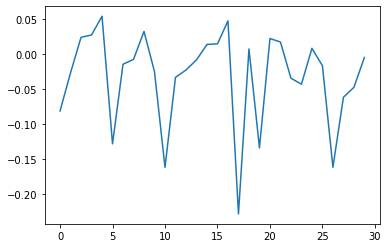

In [13]:
import matplotlib.pyplot as plt

plt.plot(res["f_val"])

## Restart an experiment
If you're not satisfied with the results and have a little more time to run your experiments, you can resume the optimization experiment for additional optimization runs. 

In [14]:
optimizer=Optimizer()
optimization_result = optimizer.resume_optimization('/content/results/test_ctm/result.json',extra_evaluations=5)

Current call:  30
Current call:  31
Current call:  32
Current call:  33
Current call:  34


## Plot the updated results

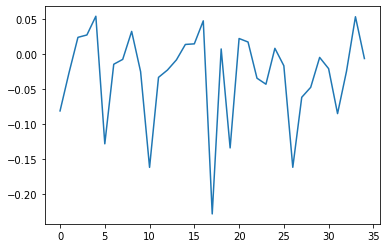

In [16]:
res = json.load(open("results/test_ctm/result.json",'r'))
plt.plot(res["f_val"])